In [9]:
import os
import sys
import pickle
import random
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt

random.seed(42)

import pandas as pd

# Load in the protein-to-gene conversion table
unimap = pd.read_csv("../data/databases/uniprot_to_gene.txt", 
                     sep = "\t", usecols=['UniProt','GeneSymbol'])

n_perm = 10000

In [10]:
def get_interactome(int_type):
    gene_file = "../intermediate/interactome_lists/{}_genes.txt".format(int_type)
    gene_list = []
    
    with open(gene_file) as f:
        for line in f:
            gene_list.append(line.strip())
            
    return gene_list

In [11]:
# Random shuffle using numpy
def np_random_shuffle(a):
    
    keys = list(a.keys())
    np.random.shuffle(keys)
    b = dict(zip(keys, a.values()))
    return(b)

# Scramble the IDs from the case and control dictionaries
def scramble_ids(case_dict, ctrl_dict):
    
    combined_dict = {**case_dict, **ctrl_dict} 
    scrambled_dict = np_random_shuffle(combined_dict)
    
    case_ids = []
    ctrl_ids = []
    for key in combined_dict:
        if key.startswith("1-") or key.startswith("GT"):
            case_ids.append(key)
        else:
            ctrl_ids.append(key)
    
    scram_case = {k: scrambled_dict[k] for k in case_ids}
    scram_ctrl = {k: scrambled_dict[k] for k in ctrl_ids}
    
    return(scram_case, scram_ctrl)

    
# Function to return n permuted odds ratios
def perm_status(case_dict, ctrl_dict, gene_list, n_perm):
    
    perm_list = []
    for i in range(0,n_perm):
        scram_case, scram_ctrl = scramble_ids(case_dict, ctrl_dict)
        perm_list.append(get_OR(scram_case, scram_ctrl, interactome))
        
    return(perm_list)
    
# Function to calculate p-value from list of permutation results
def perm_res(perm_list, true_OR):
    
    nGreater = len([num for num in perm_list if num > true_OR])
    pval = nGreater/len(perm_list)
    minp = 1/len(perm_list)
    
    if nGreater == 0:
        pval = "<{}".format(minp)
        
    return(pval)

In [12]:
def get_dnv_dicts(mut_type, unknown=False):
    
    mut_str_dict = {'LoF':['non','frameshift','startloss','stoploss','loss of function'],
                    'misD':['misD'], 'splice_':['splice'], 'mis_':['mis','misD'],
                   'allmuts':['non','frameshift','startloss','stoploss','misD','splice','mis',
                              'loss of function'],
                   'allmis':['misD','mis']}
    
    CHD_proband_dict = defaultdict(list)
    ASD_sibling_dict = defaultdict(list)
    
    if mut_type == "syn":
        case_file = "../data/variants/DNV_cases_syn.csv"
        ctrl_file = "../data/variants/DNV_ctrls_syn.csv"
        
        with open(case_file) as f:
            first_line = f.readline()
            gene_idx = first_line.split(',').index('Gene')
            for line in f:
                line_array = line.split(',')
                
                if unknown==True:
                    if line_array[gene_idx] in known_genes:
                        continue

                CHD_proband_dict[line_array[0]].append(line_array[gene_idx])

        with open(ctrl_file) as f:
            first_line = f.readline()
            gene_idx = first_line.split(',').index('Gene')
            for line in f:
                line_array = line.split(',')
                
                if unknown==True:
                    if line_array[gene_idx] in known_genes:
                        continue

                ASD_sibling_dict[line_array[0]].append(line_array[gene_idx])
                    
    else:
        case_file = "../data/variants/DNV_cases_nonsyn.csv"
        ctrl_file = "../data/variants/DNV_ctrls_nonsyn.csv"

        with open(case_file) as f:
            first_line = f.readline()
            gene_idx = first_line.split(',').index('Gene')
            class_idx = first_line.split(',').index('Variant Class')
            
            for line in f:
                line_array = line.split(',')
                
                if unknown==True:
                    if line_array[gene_idx] in known_genes:
                        continue

                if line_array[class_idx] in mut_str_dict[mut_type]:
                    CHD_proband_dict[line_array[0]].append(line_array[gene_idx])

        with open(ctrl_file) as f:
            first_line = f.readline()
            gene_idx = first_line.split(',').index('Gene')
            class_idx = first_line.split(',').index('Variant Class')
            
            for line in f:
                line_array = line.split(',')
                
                if unknown==True:
                    if line_array[gene_idx] in known_genes:
                        continue

                if line_array[class_idx] in mut_str_dict[mut_type]:
                    ASD_sibling_dict[line_array[0]].append(line_array[gene_idx])

    return CHD_proband_dict, ASD_sibling_dict

# Add empty placeholders for individuals with no called de novos in either category
def add_placeholders(variant_dict, expected_n):
    
    if len(variant_dict) < expected_n:
        n_placeholders = expected_n - len(variant_dict)
        ids = range(0,n_placeholders)
        for i in ids:
            variant_dict["placeholder{}".format(i)] = []

    return(variant_dict)

In [13]:
# Functions to calculate odds ratio
def get_OR(case_dict, ctrl_dict, gene_list, truth = False):
    
    case_ct, case_non_ct = get_ctable(case_dict, gene_list)
    ctrl_ct, ctrl_non_ct = get_ctable(ctrl_dict, gene_list)
                
    # Add pseudocount if any values are equal to zero
    if 0 in [case_ct, case_non_ct, ctrl_ct, ctrl_non_ct]:
        case_ct+=0.5; case_non_ct+=0.5; ctrl_ct+=0.5; ctrl_non_ct+=0.5;
        
    # Calculate odds ratio
    odds = (case_ct * ctrl_non_ct) / (ctrl_ct * case_non_ct)
        
    # Print contingency table, if it's the true odds ratio
    if truth == True:
        print("Case interactome muts: {}".format(case_ct))
        print("Case non-interactome muts: {}".format(case_non_ct))
        print("Ctrl interactome muts: {}".format(ctrl_ct))
        print("Ctrl non-interactome muts: {}".format(ctrl_non_ct))
        print("Odds ratio: {}".format(odds))
        
    return(odds)

# Function to iterate through dictionary, returning contingency table
def get_ctable(dictionary, gene_list):
    yes_ct = 0; no_ct = 0
    
    # Create contingency table - get yes and no values
    for indi in dictionary:
        
        for genes in dictionary[indi]:

            if (genes in gene_list):
                yes_ct += 1
            else:
                no_ct += 1
                
    return(yes_ct, no_ct)

In [14]:
# save out figure and text file
def permutation_visualization(perm_list, OR, mut_type):
    
    pval = perm_res(perm_list, OR)
    print("P-value: ", pval)
    mut_str = mut_type.split("_")[0]
    
    # Plot - original
    plt.clf()
    plt.hist(perm_list)
    plt.suptitle('{} mutations'.format(mut_str), fontsize=18)
    plt.figtext(0.99, 0.01, 'p-value = {}'.format(pval), horizontalalignment='right')
    plt.xlabel('Odds Ratios', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    ax = plt.axvline(OR, color='red', linewidth=2)
    plt.show()

In [15]:
# Known CHD-associated genes
fname = "../data/databases/known_CHD_genes.txt"
known_genes = []
with open(fname) as f:
    for line in f:
        known_genes.append(line.strip())

205
syn
Case interactome muts: 6
Case non-interactome muts: 695
Ctrl interactome muts: 10
Ctrl non-interactome muts: 474
Odds ratio: 0.4092086330935252
Normalized Odds Ratio:  1.0
allmuts
Case interactome muts: 60
Case non-interactome muts: 2229
Ctrl interactome muts: 15
Ctrl non-interactome muts: 1331
Odds ratio: 2.388515029161059
Normalized Odds Ratio:  5.836912606423825
Adjusted P-value:  <0.0001
P-value:  <0.0001


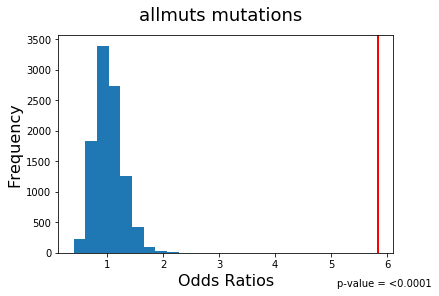

205
syn
Case interactome muts: 6
Case non-interactome muts: 675
Ctrl interactome muts: 9
Ctrl non-interactome muts: 467
Odds ratio: 0.46123456790123457
Normalized Odds Ratio:  1.0
allmuts
Case interactome muts: 34
Case non-interactome muts: 2101
Ctrl interactome muts: 15
Ctrl non-interactome muts: 1302
Odds ratio: 1.4046644455021418
Normalized Odds Ratio:  3.045444863106892
Adjusted P-value:  0.0002
P-value:  0.0002


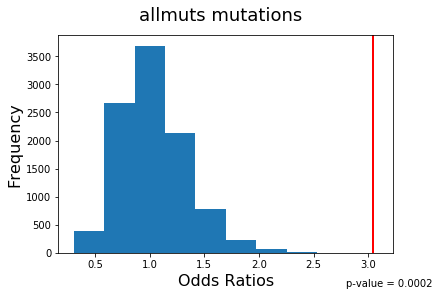

64
syn
Case interactome muts: 4
Case non-interactome muts: 697
Ctrl interactome muts: 3
Ctrl non-interactome muts: 481
Odds ratio: 0.9201339072214252
Normalized Odds Ratio:  1.0
allmuts
Case interactome muts: 16
Case non-interactome muts: 2273
Ctrl interactome muts: 2
Ctrl non-interactome muts: 1344
Odds ratio: 4.730312362516498
Normalized Odds Ratio:  5.140895608119541
Adjusted P-value:  0.0005
P-value:  0.0005


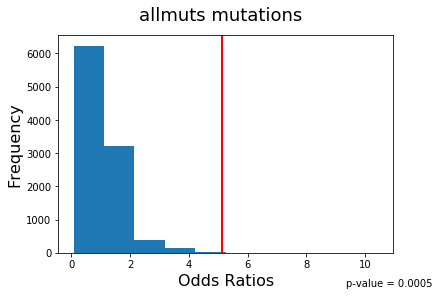

64
syn
Case interactome muts: 4
Case non-interactome muts: 677
Ctrl interactome muts: 3
Ctrl non-interactome muts: 473
Odds ratio: 0.931560807483998
Normalized Odds Ratio:  0.9999999999999999
allmuts
Case interactome muts: 8
Case non-interactome muts: 2127
Ctrl interactome muts: 2
Ctrl non-interactome muts: 1315
Odds ratio: 2.4729666196520923
Normalized Odds Ratio:  2.6546486281783293
Adjusted P-value:  0.0869
P-value:  0.0869


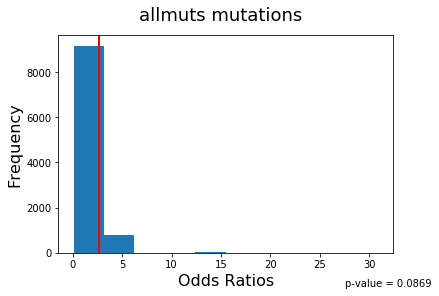

259
syn
Case interactome muts: 10
Case non-interactome muts: 691
Ctrl interactome muts: 12
Ctrl non-interactome muts: 472
Odds ratio: 0.5692233478051134
Normalized Odds Ratio:  1.0
allmuts
Case interactome muts: 74
Case non-interactome muts: 2215
Ctrl interactome muts: 17
Ctrl non-interactome muts: 1329
Odds ratio: 2.611764705882353
Normalized Odds Ratio:  4.588295114656032
Adjusted P-value:  <0.0001
P-value:  <0.0001


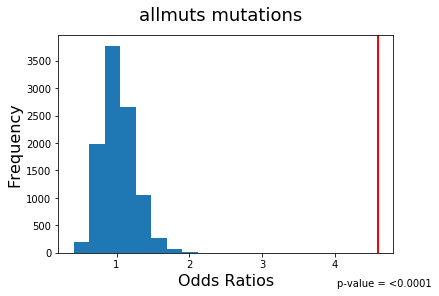

259
syn
Case interactome muts: 10
Case non-interactome muts: 671
Ctrl interactome muts: 11
Ctrl non-interactome muts: 465
Odds ratio: 0.6299959355100935
Normalized Odds Ratio:  1.0
allmuts
Case interactome muts: 40
Case non-interactome muts: 2095
Ctrl interactome muts: 17
Ctrl non-interactome muts: 1300
Odds ratio: 1.4600589639196968
Normalized Odds Ratio:  2.317568862944362
Adjusted P-value:  0.0011
P-value:  0.0011


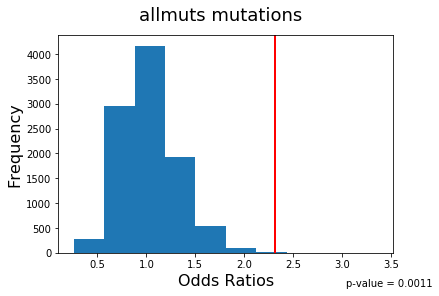

142
syn
Case interactome muts: 6
Case non-interactome muts: 695
Ctrl interactome muts: 4
Ctrl non-interactome muts: 480
Odds ratio: 1.0359712230215827
Normalized Odds Ratio:  1.0
allmuts
Case interactome muts: 28
Case non-interactome muts: 2261
Ctrl interactome muts: 11
Ctrl non-interactome muts: 1335
Odds ratio: 1.50295524908528
Normalized Odds Ratio:  1.4507693029364856
Adjusted P-value:  0.1223
P-value:  0.1223


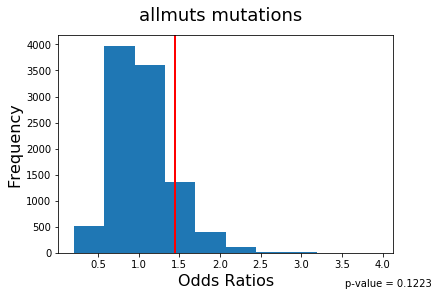

142
syn
Case interactome muts: 6
Case non-interactome muts: 675
Ctrl interactome muts: 4
Ctrl non-interactome muts: 472
Odds ratio: 1.048888888888889
Normalized Odds Ratio:  1.0
allmuts
Case interactome muts: 22
Case non-interactome muts: 2113
Ctrl interactome muts: 11
Ctrl non-interactome muts: 1306
Odds ratio: 1.2361571225745385
Normalized Odds Ratio:  1.1785396295731827
Adjusted P-value:  0.324
P-value:  0.324


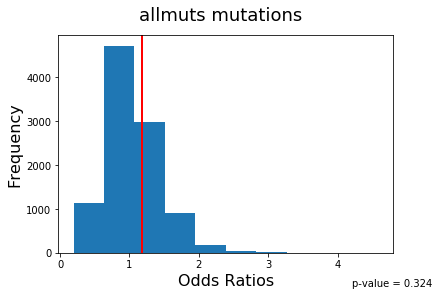

90
syn
Case interactome muts: 3
Case non-interactome muts: 698
Ctrl interactome muts: 1
Ctrl non-interactome muts: 483
Odds ratio: 2.0759312320916905
Normalized Odds Ratio:  1.0
allmuts
Case interactome muts: 21
Case non-interactome muts: 2268
Ctrl interactome muts: 5
Ctrl non-interactome muts: 1341
Odds ratio: 2.4833333333333334
Normalized Odds Ratio:  1.1962502875546355
Adjusted P-value:  0.2976
P-value:  0.2976


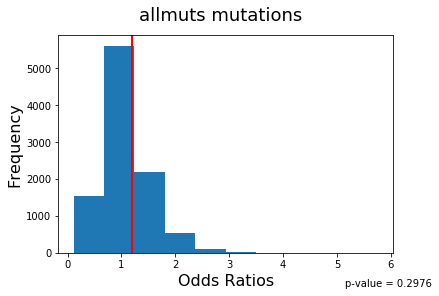

90
syn
Case interactome muts: 3
Case non-interactome muts: 678
Ctrl interactome muts: 1
Ctrl non-interactome muts: 475
Odds ratio: 2.101769911504425
Normalized Odds Ratio:  1.0
allmuts
Case interactome muts: 16
Case non-interactome muts: 2119
Ctrl interactome muts: 5
Ctrl non-interactome muts: 1312
Odds ratio: 1.981311939594148
Normalized Odds Ratio:  0.9426873649437421
Adjusted P-value:  0.5364
P-value:  0.5364


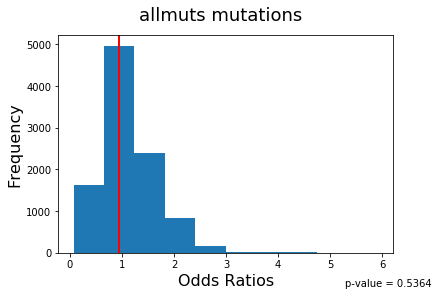

184
syn
Case interactome muts: 7
Case non-interactome muts: 694
Ctrl interactome muts: 5
Ctrl non-interactome muts: 479
Odds ratio: 0.9662824207492795
Normalized Odds Ratio:  1.0
allmuts
Case interactome muts: 38
Case non-interactome muts: 2251
Ctrl interactome muts: 15
Ctrl non-interactome muts: 1331
Odds ratio: 1.4979416555604916
Normalized Odds Ratio:  1.5502110184297364
Adjusted P-value:  0.0581
P-value:  0.0581


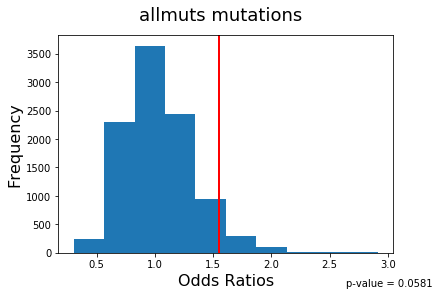

184
syn
Case interactome muts: 7
Case non-interactome muts: 674
Ctrl interactome muts: 5
Ctrl non-interactome muts: 471
Odds ratio: 0.9783382789317507
Normalized Odds Ratio:  1.0
allmuts
Case interactome muts: 32
Case non-interactome muts: 2103
Ctrl interactome muts: 15
Ctrl non-interactome muts: 1302
Odds ratio: 1.3207798383262006
Normalized Odds Ratio:  1.350023674600939
Adjusted P-value:  0.1511
P-value:  0.1511


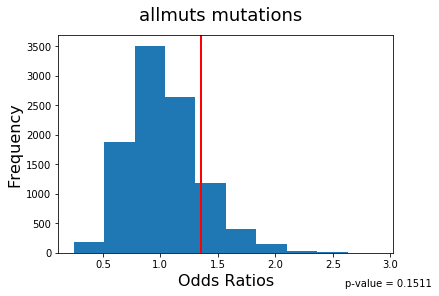

In [16]:
results_list = []

for int_type in ["GATA4","TBX5","GATA4-TBX5","HEK-GATA4","HEK-TBX5","HEKGATA4-HEKTBX5"]:
    
    for known_status in ["allGenes","unknownGenes"]:

        interactome = get_interactome(int_type)
        print(len(interactome))

        # Get OR correction figure
        mut_type = "syn"
        print(mut_type)

        # Reduce dictionaries to desired MAF cutoff
        if known_status == "allGenes":
            probands, siblings = get_dnv_dicts(mut_type)
        else:
            probands, siblings = get_dnv_dicts(mut_type, True)

        # Account for individuals without DNMs
        probands = add_placeholders(probands, 2645)
        siblings = add_placeholders(siblings, 1789)

        # Get true odds ratio
        original_OR = get_OR(probands, siblings, interactome, truth=True)

        # Find correction
        correction_val = 1/original_OR

        # Run permutations, correct values with or_correction
        perm_list = perm_status(probands,siblings,interactome,n_perm)
        normalized_OR = original_OR * correction_val
        print("Normalized Odds Ratio: ", normalized_OR)

        pval = perm_res(perm_list, original_OR)
        keystr = "{}_{}_{}_original_denovo".format(int_type, mut_type, known_status)
        results_list.append([keystr, original_OR, pval])

        pval = perm_res(perm_list, normalized_OR)
        keystr = "{}_{}_{}_syn-corrected_denovo".format(int_type, mut_type, known_status)
        results_list.append([keystr, normalized_OR, pval])


        # Print pvalues, save perm_lists for different stratifications of LoF minor allele frequency (MAF)
        for mut_type in ['allmuts']:
            print(mut_type)

            # Reduce dictionaries to desired MAF cutoff
            if known_status == "allGenes":
                probands, siblings = get_dnv_dicts(mut_type)
            else:
                probands, siblings = get_dnv_dicts(mut_type, True)

            # Get true odds ratio
            probands = add_placeholders(probands, 2645)
            siblings = add_placeholders(siblings, 1789)
            original_OR = get_OR(probands, siblings, interactome, truth=True)

            # Get 1000 permutations and read out results
            perm_list = perm_status(probands,siblings,interactome,n_perm)
            normalized_OR = original_OR * correction_val
            print("Normalized Odds Ratio: ", normalized_OR)

            pval = perm_res(perm_list, original_OR)
            keystr = "{}_nonsyn_{}_original_denovo".format(int_type, known_status)
            results_list.append([keystr, original_OR, pval])

            pval = perm_res(perm_list, normalized_OR)
            print("Adjusted P-value: ", pval)
            keystr = "{}_nonsyn_{}_syn-corrected_denovo".format(int_type, known_status)
            results_list.append([keystr, normalized_OR, pval])
            
            permutation_visualization(perm_list, normalized_OR, mut_type)

        

In [17]:
def get_lof_dicts(mut_type = "lof", unknown_only = False):
    
    print(mut_type)

    case_file = "../data/variants/LoF_cases.csv"
    ctrl_file = "../data/variants/LoF_ctrls.csv"

    CHD_proband_dict = get_id_dict(case_file, unknown_only = unknown_only)
    ASD_sibling_dict = get_id_dict(ctrl_file, unknown_only = unknown_only)
 
    return CHD_proband_dict, ASD_sibling_dict

def get_id_dict(filename, unknown_only = False):
    
    id_dict = defaultdict(list)
    with open(filename) as f:
        
        first_line = f.readline().strip().split(',')
        gene_idx = next(x for x,val in enumerate(first_line) if val == "Gene")
        class_idx = next(x for x,val in enumerate(first_line) if val in ['Variant.Class','Variant_Class',
                                                                         'Variant Class','ExonicFunc.refGene'])
        next(f)
        
        for line in f:
            line_array = line.split(',')
            
            # Ignore if it's a known gene and we're ignoring them
            if unknown_only==True:
                if line_array[gene_idx] in known_genes:
                    continue
            # Only save to dictionary if it's in the type of variants we're analyzing
            id_dict[line_array[0]].append(line_array[gene_idx])
                
    return id_dict

205
lof
Case interactome muts: 74
Case non-interactome muts: 12257
Ctrl interactome muts: 75
Ctrl non-interactome muts: 13194
Odds ratio: 1.0620934975932121
Odds Ratio:  1.0620934975932121
P-value:  0.3601
P-value:  0.3601


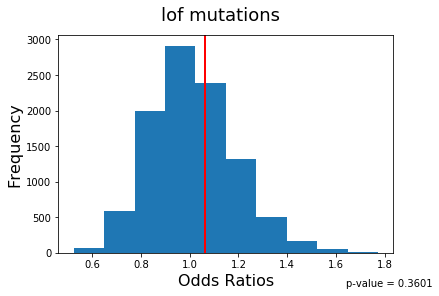

lof
Case interactome muts: 69
Case non-interactome muts: 12020
Ctrl interactome muts: 70
Ctrl non-interactome muts: 12987
Odds ratio: 1.0650142619443783
Odds Ratio:  1.0650142619443783
P-value:  0.3471
P-value:  0.3471


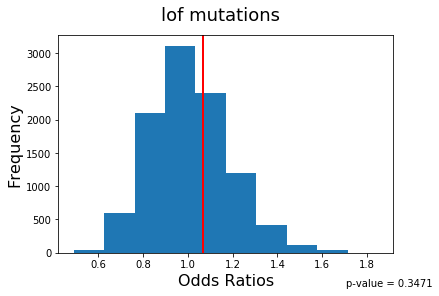

64
lof
Case interactome muts: 24
Case non-interactome muts: 12307
Ctrl interactome muts: 28
Ctrl non-interactome muts: 13241
Odds ratio: 0.9221929447817154
Odds Ratio:  0.9221929447817154
P-value:  0.5871
P-value:  0.5871


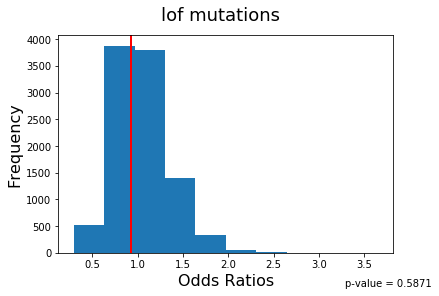

lof
Case interactome muts: 23
Case non-interactome muts: 12066
Ctrl interactome muts: 27
Ctrl non-interactome muts: 13030
Odds ratio: 0.9199096328219484
Odds Ratio:  0.9199096328219484
P-value:  0.6016
P-value:  0.6016


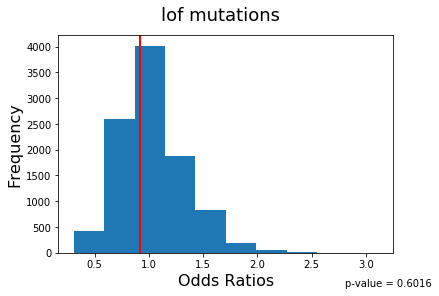

259
lof
Case interactome muts: 89
Case non-interactome muts: 12242
Ctrl interactome muts: 98
Ctrl non-interactome muts: 13171
Odds ratio: 0.9770804090301372
Odds Ratio:  0.9770804090301372


KeyboardInterrupt: 

In [18]:
for int_type in ["GATA4","TBX5","GATA4-TBX5","HEK-GATA4","HEK-TBX5","HEKGATA4-HEKTBX5"]:
    
    interactome = get_interactome(int_type)
    print(len(interactome))
    
    for known_status in ["allGenes","unknownGenes"]:
        
        ### LOF 
        mut_type = "lof"
        if known_status == "allGenes":
            probands, siblings = get_lof_dicts(mut_type)
        else:
            probands, siblings = get_lof_dicts(mut_type, True)
            
        # Get true odds ratio
        OR = get_OR(probands, siblings, interactome, truth=True)
        print("Odds Ratio: ", OR)
        
        # Get 1000 permutations and read out results
        perm_list = perm_status(probands,siblings,interactome,n_perm)

        pval = perm_res(perm_list, OR)
        print("P-value: ", pval)
        keystr = "inh-{}_nonsyn_{}_original_denovo".format(int_type, known_status)
        results_list.append([keystr, OR, pval])
        
        permutation_visualization(perm_list, OR, mut_type)
        

In [ ]:
combined = pd.DataFrame(results_list)
combined.columns = ['permutation','OR','PVAL']
combined[['Interactome','MutationType','GeneList','ORType','Inheritance']] = combined['permutation'].str.split("_",expand=True) 
combined.head()


In [ ]:
# Separate by distinct tests

known_CP_keep = ['GATA4_inh-lof_allGenes_original_inherited','GATA4_nonsyn_allGenes_syn-corrected_denovo',
                 'TBX5_inh-lof_allGenes_original_inherited','TBX5_nonsyn_allGenes_syn-corrected_denovo']

known_HEK_keep = ['HEK-GATA4_inh-lof_allGenes_original_inherited','HEK-GATA4_nonsyn_allGenes_syn-corrected_denovo',
                  'HEK-TBX5_inh-lof_allGenes_original_inherited','HEK-TBX5_nonsyn_allGenes_syn-corrected_denovo']

unknown_CP_keep =['GATA4_inh-lof_unknownGenes_original_inherited','GATA4_nonsyn_unknownGenes_syn-corrected_denovo',
                  'TBX5_inh-lof_unknownGenes_original_inherited','TBX5_nonsyn_unknownGenes_syn-corrected_denovo']

unknown_HEK_keep = ['HEK-GATA4_inh-lof_unknownGenes_original_inherited','HEK-GATA4_nonsyn_unknownGenes_syn-corrected_denovo', 
                    'HEK-TBX5_inh-lof_unknownGenes_original_inherited','HEK-TBX5_nonsyn_unknownGenes_syn-corrected_denovo']



In [ ]:
df_list = []
from statsmodels.stats.multitest import multipletests

for keep in [known_CP_keep, known_HEK_keep, unknown_CP_keep, unknown_HEK_keep]:
    print(keep)
    r = (combined.loc[combined['permutation'].isin(keep)])
    print(r)
    r['PVAL'] = r['PVAL'].replace('<0.0001','0.00009')
    r['BH-corrected PVAL'] = multipletests(r['PVAL'].astype(float),method='fdr_bh')[1]
    df_list.append(r)
    
c=pd.concat(df_list)
c.head()

In [ ]:
c

In [14]:
c.to_csv("../manuscript/tables/permutation_results.csv", index=False)

In [15]:
# Function to contingency table counts
def get_counts(case_dict, ctrl_dict, gene_list, truth = False):
    
    case_ct, case_non_ct = get_ctable(case_dict, gene_list)
    ctrl_ct, ctrl_non_ct = get_ctable(ctrl_dict, gene_list)
                
    # Add pseudocount if any values are equal to zero
    if 0 in [case_ct, case_non_ct, ctrl_ct, ctrl_non_ct]:
        case_ct+=0.5; case_non_ct+=0.5; ctrl_ct+=0.5; ctrl_non_ct+=0.5;
        
    # Calculate odds ratio
    odds = (case_ct * ctrl_non_ct) / (ctrl_ct * case_non_ct)
        
    # Print contingency table, if it's the true odds ratio
    if truth == True:
        print("Case interactome muts: {}".format(case_ct))
        print("Case non-interactome muts: {}".format(case_non_ct))
        print("Ctrl interactome muts: {}".format(ctrl_ct))
        print("Ctrl non-interactome muts: {}".format(ctrl_non_ct))
        print("Odds ratio: {}".format(odds))
        
    return([case_ct, case_non_ct, ctrl_ct, ctrl_non_ct, odds])

In [16]:
# Create a count table for all tests of interest

res_list = []

for int_type in ["GATA4","TBX5","GATA4-TBX5","HEK-GATA4","HEK-TBX5","HEKGATA4-HEKTBX5"]:
    
    interactome = get_interactome(int_type)
    print(len(interactome))
        
    for known_status in ["allGenes","unknownGenes"]:
            
        # Inherited loss of function data
        if known_status == "allGenes":
            probands, siblings = get_lof_dicts()
        else:
            probands, siblings = get_lof_dicts('lof', True)
        ls = get_counts(probands, siblings, interactome, truth=True)
        ls.append("{}_inh-lof_{}".format(int_type, known_status))
        res_list.append(ls)

        # De novo data
        mut_type = "allmuts"
        if known_status == "allGenes":
            probands, siblings = get_dnv_dicts(mut_type)
        else:
            probands, siblings = get_dnv_dicts(mut_type, True)

        # Get odds ratio
        ls = get_counts(probands, siblings, interactome, truth=True)
        ls.append("{}_nonsyn-dnv_{}".format(int_type, known_status))
        res_list.append(ls)

        # Synonymous data
        mut_type = "syn"
        if known_status == "allGenes":
            probands, siblings = get_dnv_dicts(mut_type)
        else:
            probands, siblings = get_dnv_dicts(mut_type, True)
        ls = get_counts(probands, siblings, interactome, truth=True)
        ls.append("{}_syn-dnv_{}".format(int_type, known_status))
        res_list.append(ls)



205
lof
Case interactome muts: 74
Case non-interactome muts: 12257
Ctrl interactome muts: 75
Ctrl non-interactome muts: 13194
Odds ratio: 1.0620934975932121
Case interactome muts: 60
Case non-interactome muts: 2229
Ctrl interactome muts: 15
Ctrl non-interactome muts: 1331
Odds ratio: 2.388515029161059
Case interactome muts: 6
Case non-interactome muts: 695
Ctrl interactome muts: 10
Ctrl non-interactome muts: 474
Odds ratio: 0.4092086330935252
lof
Case interactome muts: 69
Case non-interactome muts: 12020
Ctrl interactome muts: 70
Ctrl non-interactome muts: 12987
Odds ratio: 1.0650142619443783
Case interactome muts: 34
Case non-interactome muts: 2101
Ctrl interactome muts: 15
Ctrl non-interactome muts: 1302
Odds ratio: 1.4046644455021418
Case interactome muts: 6
Case non-interactome muts: 675
Ctrl interactome muts: 9
Ctrl non-interactome muts: 467
Odds ratio: 0.46123456790123457
64
lof
Case interactome muts: 24
Case non-interactome muts: 12307
Ctrl interactome muts: 28
Ctrl non-interact

In [ ]:
res_df = pd.DataFrame(res_list, columns = ['case_interactome', 'case_noninteractome', 
                                  'ctrl_interactome', 'ctrl_noninteractome', 'uncorrected_odds','test'])

res_df[['Interactome','MutationType','GeneList']] = res_df['test'].str.split("_",expand=True) 
res_df.to_csv('../manuscript/tables/contingency_counts.csv')
res_df

In [17]:
res_df = pd.DataFrame(res_list, columns = ['case_interactome', 'case_noninteractome', 
                                  'ctrl_interactome', 'ctrl_noninteractome', 'uncorrected_odds','test'])

res_df[['Interactome','MutationType','GeneList']] = res_df['test'].str.split("_",expand=True) 
res_df.to_csv('../manuscript/tables/contingency_counts.csv')
res_df

,case_interactome,case_noninteractome,ctrl_interactome,ctrl_noninteractome,uncorrected_odds,test,Interactome,MutationType,GeneList
0,74,12257,75,13194,1.062093,GATA4_inh-lof_allGenes,GATA4,inh-lof,allGenes
1,60,2229,15,1331,2.388515,GATA4_nonsyn-dnv_allGenes,GATA4,nonsyn-dnv,allGenes
2,6,695,10,474,0.409209,GATA4_syn-dnv_allGenes,GATA4,syn-dnv,allGenes
3,69,12020,70,12987,1.065014,GATA4_inh-lof_unknownGenes,GATA4,inh-lof,unknownGenes
4,34,2101,15,1302,1.404664,GATA4_nonsyn-dnv_unknownGenes,GATA4,nonsyn-dnv,unknownGenes
5,6,675,9,467,0.461235,GATA4_syn-dnv_unknownGenes,GATA4,syn-dnv,unknownGenes
6,24,12307,28,13241,0.922193,TBX5_inh-lof_allGenes,TBX5,inh-lof,allGenes
7,16,2273,2,1344,4.730312,TBX5_nonsyn-dnv_allGenes,TBX5,nonsyn-dnv,allGenes
8,4,697,3,481,0.920134,TBX5_syn-dnv_allGenes,TBX5,syn-dnv,allGenes
9,23,12066,27,13030,0.919910,TBX5_inh-lof_unknownGenes,TBX5,inh-lof,unknownGenes
